In [1]:
import pandas as pd
from datetime import datetime, timedelta
import cartopy.crs as crs
import cartopy.feature as feat
import matplotlib.pyplot as plt
import numpy as np


In [2]:
latMin = np.mod(36, 360)
latMax = np.mod(48, 360)
lonMin = 46
lonMax = 55
def windowToAxes(window):
    return [window[0]['lon'], window[1]['lon'], window[1]['lat'], window[0]['lat']]

window = [{'lat': latMax, 'lon': lonMax}, {'lat': latMin, 'lon': lonMin}]

In [3]:
# 2021 path has a different CF convention. therefore also changed surface type flag
data2016Path = "./reduced_caspian_2016.csv"
data2017Path = "./reduced_caspian_2017.csv"
data2018Path = "./reduced_caspian_2018.csv"
data2019Path = "./reduced_caspian_2019.csv"
data2020Path = "./reduced_caspian_2020.csv"
data2021Path = "./reduced_caspian_2021.csv"
dataSentinel2021Path =  "./reduced_caspian_sentinel_2021.csv"
dataSentinel2022Path =  "./reduced_caspian_sentinel_2022.csv"

surface_type_flag = 2
df2016 = pd.read_csv(data2016Path)
df2017 = pd.read_csv(data2017Path)
df2018 = pd.read_csv(data2018Path)
df2019 = pd.read_csv(data2019Path)
df2020 = pd.read_csv(data2020Path)
df2021 = pd.read_csv(data2021Path)
dfSentinel2021 = pd.read_csv(dataSentinel2021Path)
dfSentinel2022 = pd.read_csv(dataSentinel2022Path)

## Plot a sample

[209. 235. 133. 168. 244.  16.  31.  57.  66.  92. 107.]


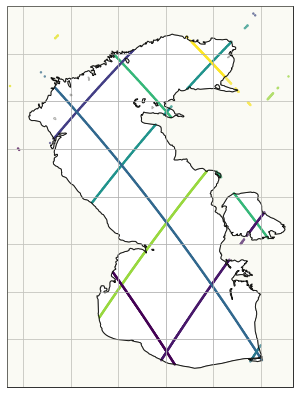

In [4]:
df = dfSentinel2021

data = df.loc[(df.month ==11) & (df["surface type"] == 2) ]# & (df["pass number"] == 31)]

fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()
ax.scatter(x=data["lon"], y=data["lat"], c=data["pass number"], s=2, transform=crs.PlateCarree(central_longitude=0))
ax.gridlines(draw_labels=False)
plt.savefig("ground_tracks_pass_numbers_surface_flag.png")

print(data["pass number"].unique())

# Find intersecting points

In [5]:
days = [x for x in range(1, 32)]
months = [1,2,3,4,5,6,7,8,9,10,11,12]
dataset = []
s6aDataset = []
monthly = []
s6aMonthly = []

datasets = [df2016, df2017, df2018, df2019, df2020, df2021, dfSentinel2021, dfSentinel2022]
#datasets = [dfSentinel2021, dfSentinel2022]

surfaceTypeFlags = [1, 1, 1, 1, 1, 2, 2, 2] # Flags corresponding to the correct dataset (CF-1.* Notation)
#surfaceTypeFlags = [2, 2]
satelliteFlag = ["jason","jason","jason","jason","jason", "jason","sentinel","sentinel"]
#satelliteFlag = ["sentinel","sentinel"]

for index, df in enumerate(datasets):
    print("dataset: {}".format(df.year.values[0]))
    satellite = satelliteFlag[index]
    for month in months:
        d = []
        surfaceType = surfaceTypeFlags[index]
        
        if str(df.year.values[0]) == "2016" and month < 7:
            print("Skipping month:", month)
            continue
            
        if "sentinel" in satellite and month < 11 and df.year.values[0] == 2021:
            print("month skipped: ", satellite, month)
            continue
        
        if "sentinel" in satellite and df.year.values[0] == 2022 and month > 4:
            print("month skipped: ", satellite, month)
            continue
            
                    
        if str(df.year.values[0]) >= "2020" and month >= 11:
            surfaceType = 2
            
        data = df.loc[(df.month == month) & (df["surface type"] == surfaceType )]
        
        print("Calculating for month:", month)

        
        # Create a list of pass numbers that has usable intersections
        passNumbersWithIntersections = [(91, 207), (91, 29), (91, 56), (91, 133), (15, 29), (15, 207), (167, 56), (243, 133)]

        # Find an intersection points between pass number
        for intersection in passNumbersWithIntersections:
            p1 = data.loc[(df["pass number"] == intersection[0])]
            p2 = data.loc[(df["pass number"] == intersection[1])]

            if (intersection[0] == 91):
                p1 = data.loc[(df["pass number"] == intersection[0]) | (df["pass number"] == 92)]
            if (intersection[0] == 15):
                p1 = data.loc[(df["pass number"] == intersection[0]) | (df["pass number"] == 16)]
            if (intersection[0] == 167):
                p1 = data.loc[(df["pass number"] == intersection[0]) | (df["pass number"] == 168)]
            if (intersection[0] == 243):
                p1 = data.loc[(df["pass number"] == intersection[0]) | (df["pass number"] == 244)]
                
                
            if (intersection[1] == 133):
                p2 = data.loc[(df["pass number"] == intersection[1]) | (df["pass number"] == 132) | (df["pass number"] == 131)]
            if (intersection[1] == 207):
                p2 = data.loc[(df["pass number"] == intersection[1]) | (df["pass number"] == 208) | (df["pass number"] == 209)]
            if (intersection[1] == 56):
                p2 = data.loc[(df["pass number"] == intersection[1]) | (df["pass number"] == 55) | (df["pass number"] == 57)]
            if (intersection[1] == 29):
                p2 = data.loc[(df["pass number"] == intersection[1]) | (df["pass number"] == 31)]
                
            v1 = np.column_stack(([p1["lat"].values, p1["lon"].values]))
            v2 = np.column_stack(([p2["lat"].values, p2["lon"].values]))

            distances = []
            indices = []
            for i, point in enumerate(v1):
                # Calculate distance to point in v2
                for j, point2 in enumerate(v2):
                    dist = np.linalg.norm(point - point2)
                    distances.append(dist)
                    indices.append((i, j))
            try:
                min_value = min(distances)
            except ValueError as e:
                print("Val error: ",e, intersection, month)
                break
            min_index = distances.index(min_value)

            k = indices[min_index]
            n = 3
            i1 = [x for x in range(k[0]-n, k[0]+n)]
            i2 = [x for x in range(k[1]-n, k[1]+n)]
            d.append(pd.concat([p1.iloc[i1], p2.iloc[i2]]))
        
        if "jason" in satellite:
            monthly.append(d)
        else:
            s6aMonthly.append(d)
           
    if "jason" in satellite:
        dataset.append(monthly)
    else:
        s6aDataset.append(s6aMonthly)
            
print("Finished")

dataset: 2016
Skipping month: 1
Skipping month: 2
Skipping month: 3
Skipping month: 4
Skipping month: 5
Skipping month: 6
Calculating for month: 7
Calculating for month: 8
Calculating for month: 9
Calculating for month: 10
Calculating for month: 11
Calculating for month: 12
dataset: 2017
Calculating for month: 1
Calculating for month: 2
Calculating for month: 3
Calculating for month: 4
Calculating for month: 5
Calculating for month: 6
Calculating for month: 7
Calculating for month: 8
Calculating for month: 9
Calculating for month: 10
Calculating for month: 11
Calculating for month: 12
dataset: 2018
Calculating for month: 1
Calculating for month: 2
Calculating for month: 3
Calculating for month: 4
Calculating for month: 5
Calculating for month: 6
Calculating for month: 7
Calculating for month: 8
Calculating for month: 9
Calculating for month: 10
Calculating for month: 11
Calculating for month: 12
dataset: 2019
Calculating for month: 1
Calculating for month: 2
Calculating for month: 3
Ca

# Create a new dataframe which contains only points near the intersections

In [6]:
averagedSSH = []
averagedMSS = []
SSH = np.zeros((0,0))
MSS = np.zeros((0,0))

dataframes = []
for i, m in enumerate(monthly):
    levels = []
    ranges = []
    altitudes = []
    for i, intersection in enumerate(m):
        ranges.append(intersection.range.values)
        altitudes.append(intersection.altitude.values)
        levels.append(intersection.mss.values)
        dataframes.append(intersection)
        
    
    rng = np.array(ranges).flatten()
    alt = np.array(altitudes).flatten()
    rngAlt = np.column_stack([rng, alt])
    rngAlt = np.delete(rngAlt, np.where(rngAlt[:,0] > 1.349699e+07)[0], axis=0)
    diff = (rngAlt[:,1] - rngAlt[:,0] )
    
    mss = np.array(levels).flatten()
    mss = np.delete(mss, np.where(mss > 1.349699e+07)[0], axis=0)

    averagedSSH.append(np.mean(diff))
    averagedMSS.append(np.mean(mss))
    
    SSH = np.append(SSH, np.array(diff).flatten())
    MSS = np.append(MSS, mss)



# Create a dataframe which separates intersections

In [34]:
intersectionListMean = []
for i, m in enumerate(monthly):
    intersectionMeans = []
    
    for i, intersection in enumerate(m):
        sshList = []
        for x in range(len(intersection.range.values)):
            if (intersection.range.values[x] > 1.349699e+07):
                continue
            ssh = intersection.altitude.values[x] - intersection.range.values[x]
            sshList.append(ssh)
        if (len(sshList)) < 1:
            sshList.append(np.nan)
        intersectionMeans.append(np.mean(np.array(sshList)))

    intersectionListMean.append(intersectionMeans)

intersectionListMean = np.array(intersectionListMean)

sentinel6 = []
for i, m in enumerate(s6aMonthly):
    intersectionMeans = []
    
    for i, intersection in enumerate(m):
        sshList = []
        for x in range(len(intersection.range.values)):
            if (intersection.range.values[x] > 1.349699e+07):
                continue
            ssh = intersection.altitude.values[x] - intersection.range.values[x]
            sshList.append(ssh)
        if (len(sshList)) < 1:
            sshList.append(np.nan)
        intersectionMeans.append(np.mean(np.array(sshList)))

    sentinel6.append(intersectionMeans)

sentinel6 = np.array(sentinel6)


In [35]:
dfinter = pd.DataFrame(intersectionListMean)
dfinter.columns = ["Intersection 1","Intersection 2", "Intersection 3", "Intersection 4", "Intersection 5", "Intersection 6", "Intersection 7", "Intersection 8", ]

dfinter.fillna(method='ffill', inplace=True)
dfinter["avg"] = dfinter.sum(axis=1, skipna=True) / 8
dfinter["month"] = dfinter.index + 7
dfinter["year"] = 2016

for i, month in enumerate(dfinter["month"]):
    dfinter.loc[dfinter['month'] > 12, "year"] = 2017
    dfinter.loc[dfinter['month'] > 24, "year"] = 2018
    dfinter.loc[dfinter['month'] > 36, "year"] = 2019
    dfinter.loc[dfinter['month'] > 48, "year"] = 2020
    dfinter.loc[dfinter['month'] > 60, "year"] = 2021
    

dfinter["month"] = dfinter["month"].apply(lambda x: 12 if ((x % 12) == 0) else x % 12)
dfinter["satellite"] = "jason-3"


## Plot averaged SSH

In [36]:
dfsentinel = pd.DataFrame(sentinel6)
dfsentinel.columns = ["Intersection 1","Intersection 2", "Intersection 3", "Intersection 4", "Intersection 5", "Intersection 6", "Intersection 7", "Intersection 8", ]

dfsentinel.fillna(method='ffill', inplace=True)
dfsentinel["avg"] = dfsentinel.sum(axis=1, skipna=True) / 8
dfsentinel["month"] = dfsentinel.index + 11
dfsentinel["year"] = 2021

for i, month in enumerate(dfsentinel["month"]):
    dfsentinel.loc[dfsentinel['month'] > 12, "year"] = 2022
    dfsentinel.loc[dfsentinel['month'] > 24, "year"] = 2022
    

dfsentinel["month"] = dfsentinel["month"].apply(lambda x: 12 if ((x % 12) == 0) else x % 12)
dfsentinel["satellite"] = "sentinel-6"


In [37]:
vertical_stack = pd.concat([dfinter, dfsentinel], axis=0)
vertical_stack.head(70)

,Intersection 1,Intersection 2,Intersection 3,Intersection 4,Intersection 5,Intersection 6,Intersection 7,Intersection 8,avg,month,year,satellite
0,-45.760417,-48.093750,-37.781250,-38.989583,-34.052083,-40.229167,-39.000000,-43.520833,-40.928385,7,2016,jason-3
1,-45.750000,-48.177083,-37.693182,-39.125000,-34.178571,-40.239583,-38.500000,-44.055556,-40.964872,8,2016,jason-3
2,-45.645833,-48.312500,-37.687500,-39.135417,-34.125000,-40.510417,-38.500000,-43.562500,-40.934896,9,2016,jason-3
3,-45.947917,-48.291667,-37.729167,-39.343750,-34.322917,-40.583333,-38.406250,-44.010417,-41.079427,10,2016,jason-3
4,-46.041667,-48.197917,-37.677083,-39.375000,-34.020833,-40.531250,-38.656250,-44.010417,-41.063802,11,2016,jason-3
...,...,...,...,...,...,...,...,...,...,...,...,...
65,-47.250000,-49.750000,-39.333333,-40.708333,-35.587500,-41.895833,-40.125000,-45.375000,-42.503125,12,2021,jason-3
0,-47.052083,-49.614583,-39.145833,-40.604167,-35.656250,-41.843750,-39.885417,-45.156250,-42.369792,11,2021,sentinel-6
1,-47.322917,-49.583333,-39.416667,-40.677083,-35.458333,-41.781250,-39.562500,-46.458333,-42.532552,12,2021,sentinel-6
2,-47.437500,-49.854167,-39.031250,-40.562500,-35.531250,-42.010417,-39.843750,-45.197917,-42.433594,1,2022,sentinel-6


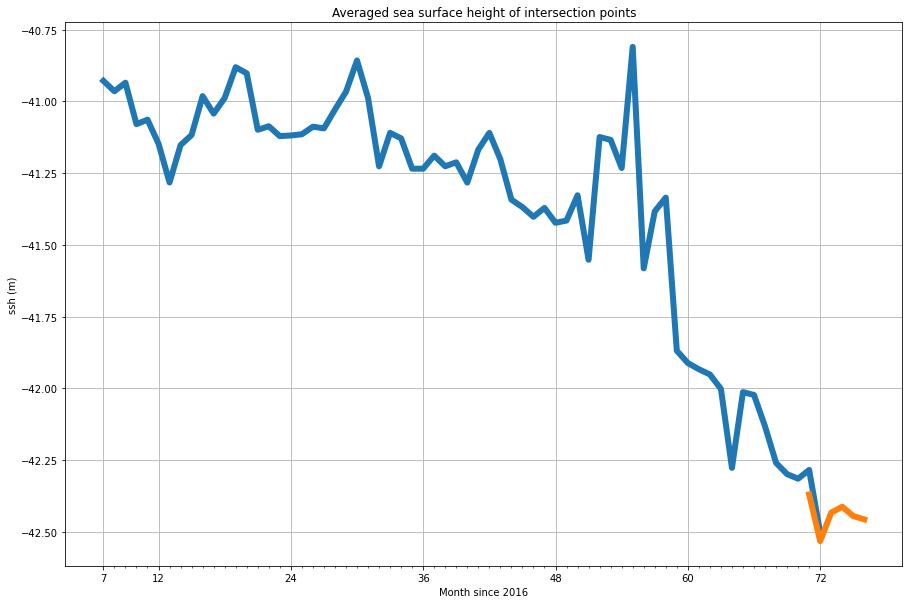

In [45]:
offset = 7

plt.rcParams['figure.figsize'] = [15, 10]

major_ticks = [7, 12, 24, 36, 48, 60, 72]
minor_ticks = np.arange(offset, len(monthly)+offset, 1)


fig, ax = plt.subplots()
ax.plot(dfinter.index + offset, dfinter.avg.values,
       linewidth=6)

ax.plot([71, 72, 73, 74, 75, 76], dfsentinel.avg.values,
       linewidth=6)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set(xlabel='Month since 2016', ylabel='ssh (m)',
       title='Averaged sea surface height of intersection points')
ax.grid()

plt.savefig("averaged_sea_surface_height.png")

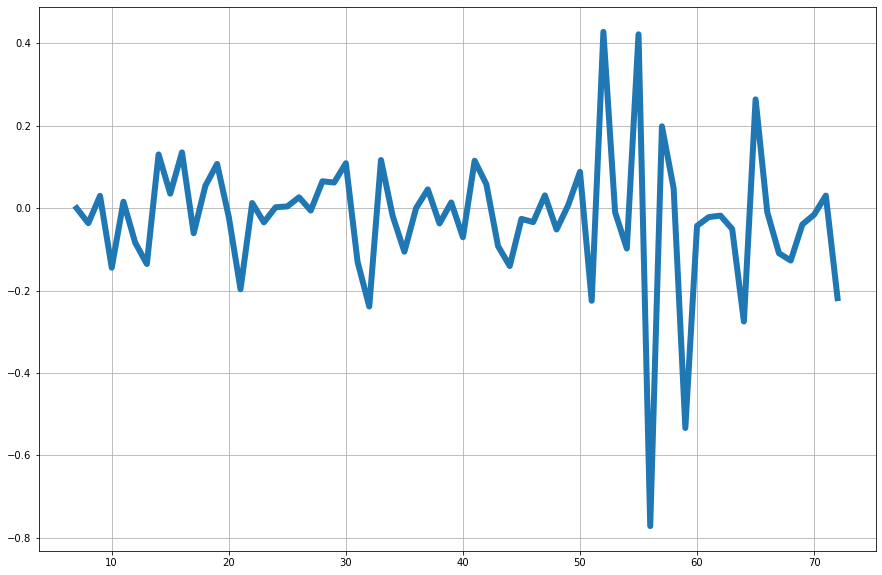

In [39]:
# Difference Transform

# difference dataset
def difference(data, interval):
    d = [0] * len(data)
    for i in range(interval, len(data)):
        d[i] = data[i] - data[i - interval]
    return d

# invert difference
def invert_difference(orig_data, diff_data, interval):
    d = [0] * len(orig_data)
    for i in range(interval, len(orig_data)):
        d[i] = diff_data[i-interval] + orig_data[i-interval]
    d[0] = d[1]
    return d
 
    
# difference transform
transformed = difference(dfinter.avg.values, 1)
dfinter["avg_transformed_ssh"] = transformed
fig, ax = plt.subplots()

ax.plot(dfinter.index + offset, transformed,
       linewidth=6)

ax.grid()

plt.show()

In [40]:
# Revert data

inverted = invert_difference(dfinter.avg.values, transformed, 1)

#fig, ax = plt.subplots()

#ax.plot(dfinter.index + offset, inverted,linewidth=6)
#ax.grid()

#plt.show()

# PLOT SSH For each Intersection

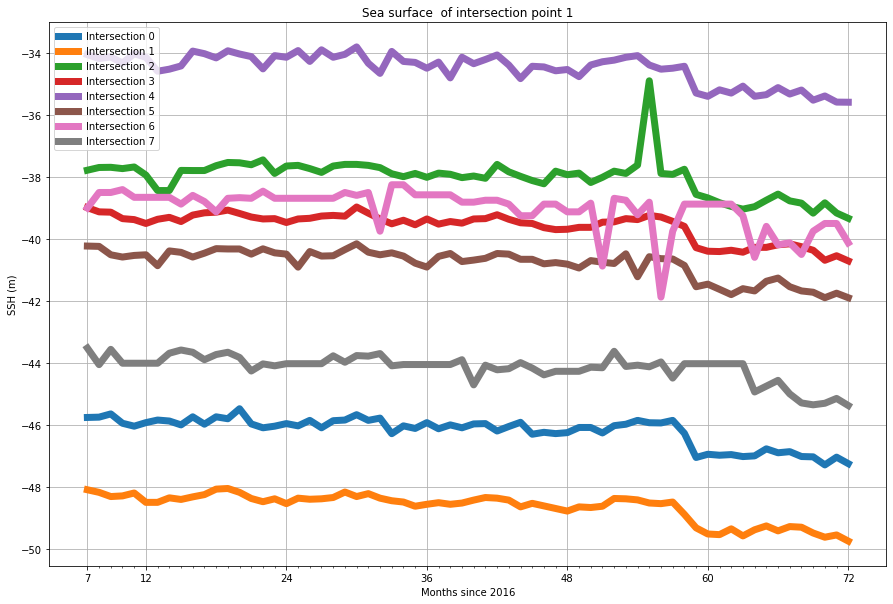

In [43]:
from cycler import cycler

plt.rcParams['figure.figsize'] = [15, 10]

minor_ticks = np.arange(offset, len(monthly)+offset, 1)

fig, ax = plt.subplots()
offset = 7

for i in range(len(intersectionListMean[0])):
    ax.plot(dfinter.index + offset, dfinter.iloc[:,i]
            ,linewidth=7
            ,label=str(dfinter.columns[i][:-1]) + str(i))
    

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set(xlabel='Months since 2016', ylabel='SSH (m)',
       title='Sea surface  of intersection point 1')
plt.legend(loc="upper left")
plt.savefig("ssh_intersections.png")
ax.grid()

# Average all intersections and plot mss for whole Caspian

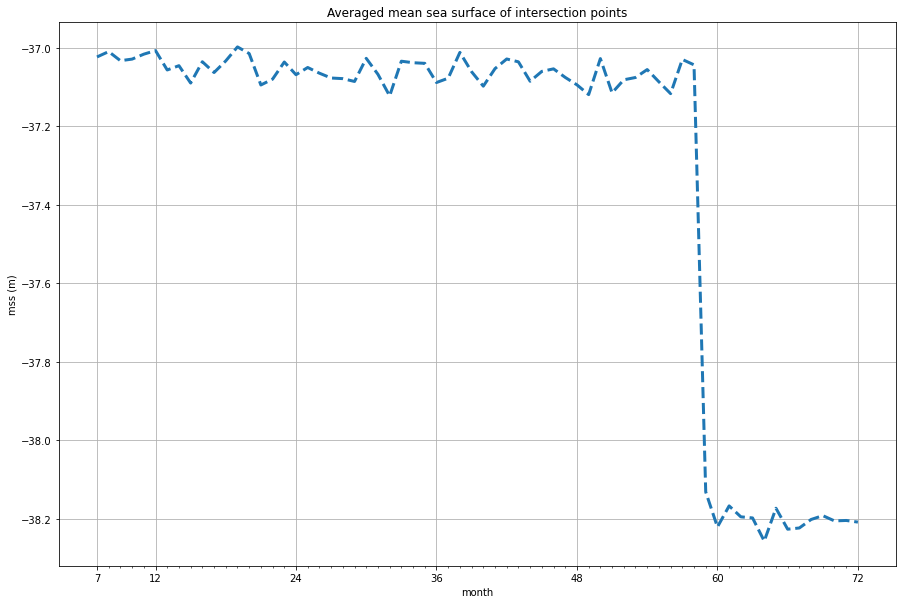

In [15]:
fig, ax = plt.subplots()
ax.plot(np.arange(offset, len(monthly)+offset, 1), averagedMSS,
       linestyle='dashed',
       linewidth=3)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set(xlabel='month', ylabel='mss (m)',
       title='Averaged mean sea surface of intersection points')
ax.grid()


TypeError: string indices must be integers

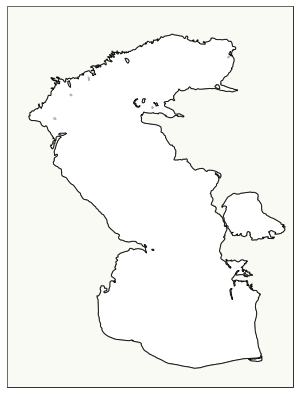

In [32]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()

for i, serie in enumerate(d):
    ax.scatter(x=serie["lon"], y=serie["lat"], c="red", s=5,  transform=crs.PlateCarree(central_longitude=0))
    plt.text(x=serie["lon"].iloc[1] + 1,
             y=serie["lat"].iloc[1]
             ,s=str(i), 
          fontdict=dict(color="red",size=20),
          bbox=dict(facecolor="yellow",alpha=1))


ax.gridlines(draw_labels=False)
plt.savefig("ssh_intersections_names.png")


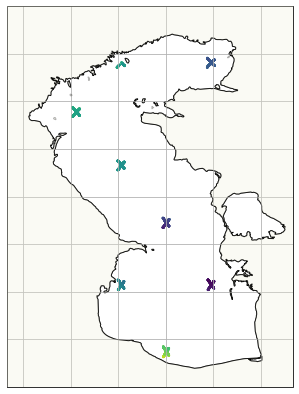

In [30]:
dfRangeFiltered = df.loc[(df["range"] < 1.349699e+07)]
rngAlt = np.column_stack([dfRangeFiltered["range"].values, dfRangeFiltered["altitude"].values])
diff = (rngAlt[:,1] - rngAlt[:,0] )

fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()
ax.scatter(x=df["lon"], y=df["lat"], c=diff, s=2, transform=crs.PlateCarree(central_longitude=0))
ax.gridlines(draw_labels=False)

plt.savefig("intersections.png")



In [18]:
# Create a collected dataframe from all datasets
df = pd.concat(dataframes)

# But drop rows where range is not providing usefull values
df = df.drop(df[df.range >  1.349699e+07].index)

sum_column = df["altitude"] - df["range"] 
df["ssh"] = sum_column

dfinter

,Intersection 1,Intersection 2,Intersection 3,Intersection 4,Intersection 5,Intersection 6,Intersection 7,Intersection 8,avg,month,year,satellite,avg_transformed_ssh
0,-45.760417,-48.093750,-37.781250,-38.989583,-34.052083,-40.229167,-39.00000,-43.520833,-40.928385,7,2016,jason-3,0.000000
1,-45.750000,-48.177083,-37.693182,-39.125000,-34.178571,-40.239583,-38.50000,-44.055556,-40.964872,8,2016,jason-3,-0.036487
2,-45.645833,-48.312500,-37.687500,-39.135417,-34.125000,-40.510417,-38.50000,-43.562500,-40.934896,9,2016,jason-3,0.029976
3,-45.947917,-48.291667,-37.729167,-39.343750,-34.322917,-40.583333,-38.40625,-44.010417,-41.079427,10,2016,jason-3,-0.144531
4,-46.041667,-48.197917,-37.677083,-39.375000,-34.020833,-40.531250,-38.65625,-44.010417,-41.063802,11,2016,jason-3,0.015625
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,-47.020833,-49.302083,-38.843750,-40.250000,-35.193182,-41.677083,-40.50000,-45.291667,-42.259825,8,2021,jason-3,-0.127131
62,-47.031250,-49.489583,-39.166667,-40.364583,-35.520833,-41.718750,-39.75000,-45.352273,-42.299242,9,2021,jason-3,-0.039418
63,-47.291667,-49.625000,-38.833333,-40.687500,-35.385417,-41.895833,-39.50000,-45.302083,-42.315104,10,2021,jason-3,-0.015862
64,-47.041667,-49.552083,-39.162500,-40.541667,-35.583333,-41.750000,-39.50000,-45.145833,-42.284635,11,2021,jason-3,0.030469


## Features and Labels

In [19]:
# Labels are the values we want to predict
labels = np.array(df['transformed_mss'])

# Remove the labels from the features
# axis 1 refers to the columns
features= df.drop('transformed_mss', axis = 1)
# Drop unused columns as well
features = features.drop(['surface type', "pass number", "geophysical quality flag", "time", "range", "altitude", "ssh", "mss"], axis= 1)

# Saving feature names for later use
feature_list = list(features.columns)
print(feature_list)
# Convert to numpy array
features = np.array(features)

KeyError: 'transformed_mss'

### Attempt 2: Using only meaned SSH for each intersection

In [ ]:
# Labels are the values we want to predict
labels = np.array(dfinter['avg_transformed_ssh'])

# Remove the labels from the features
# axis 1 refers to the columns
features= dfinter.drop('avg_transformed_ssh', axis = 1)
# Drop unused columns as well
features = features.drop(["Intersection 1","Intersection 2", "Intersection 3", "Intersection 4", "Intersection 5", "Intersection 6", "Intersection 7", "Intersection 8", "avg" ]
, axis= 1)

# Saving feature names for later use
feature_list = list(features.columns)
print(feature_list)
# Convert to numpy array
features = np.array(features)

## Training and test sets

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

## Training the Forest

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 2000, bootstrap=True)

# Train the model on training data
rf.fit(train_features, train_labels);

# Predictions

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4) * 100, 'cm')

# Visualize a single tree

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

![Decision Tree](tree.png)

In [ ]:
print('The depth of this tree is:', tree.tree_.max_depth)

## Attempt 1: Predicting in the future and plotting using location and date

In [ ]:
import random
from dateutil.relativedelta import relativedelta

date_from = datetime(2016, 8, 1)
dateTimes = []
year = []
month = []
day = []
lat = []
lon = []

years = 15

for x in range(12 * years):
    date = date_from + relativedelta(months=+x)
    dateTimes.append(date)
    year.append(date.year)
    month.append(date.month)
    day.append(date.day)
    
    lon.append(random.uniform(46, 55))
    lat.append(random.uniform(36, 48))
    
    #lon.append(49)
    #lat.append(38)

res = np.column_stack([lat, lon, day, month, year])
future_pred = rf.predict(res)

dfTest = pd.DataFrame(res)
dfTest.columns = ["lat", "lon", "day", "month", "year"]


## Attempt 2: Predicting current dates

In [ ]:
dfTrain = df.drop(["lat", "lon", "day", 'surface type', "pass number", "geophysical quality flag", "time", "range", "altitude", "ssh" , "mss"], axis= 1)
dfActual =  df.drop(['surface type', "pass number", "geophysical quality flag", "time", "range", "altitude", "ssh" ], axis= 1)
dfTrain = dfTrain.sample(n=res.shape[0])

current_pred = rf.predict(np.array(dfTrain))

dfActual = dfActual.sample(n=100)
dfActual.sort_values(by=['year','month', 'day'], inplace=True)

dfActual = dfActual.loc[(dfActual['lat'] >= 36) & (dfActual['lat'] <= 48)]
dfActual = dfActual.loc[(dfActual['lon'] >= 46) & (dfActual['lon'] <= 55)]

actualDateTimes = []
actualMSS = []
for x in range(len(dfActual["day"].values)):
    date = datetime(int(dfActual["year"].values[x]), int(dfActual["month"].values[x]), int(dfActual["day"].values[x]))
    actualDateTimes.append(date)
    actualMSS.append(dfActual["mss"].values[x])


## Attempt2: predicting future dates

In [ ]:
import random
from dateutil.relativedelta import relativedelta

date_from = datetime(2016,6, 1)
dateTimes = []
year = []
month = []

years = 15

for x in range(12 * years):
    date = date_from + relativedelta(months=+x)
    dateTimes.append(date)
    year.append(date.year)
    month.append(date.month)

res = np.column_stack([month, year])
future_pred = rf.predict(res)

dfTest = pd.DataFrame(res)
dfTest.columns = ["month", "year"]


In [ ]:
# Plot the actual values
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=10))


x = [x for x in range(1,  len(future_pred) + 1)]

#major_ticks = [1, 12, 24, 36, 48, 60, 72, 84, 96]
#minor_ticks = np.arange(1, len(future_pred), 1)

#fig, ax = plt.subplots()
#offset = 7

#ax.plot(x, future_pred, '--', label = 'predicted')


plt.plot(dateTimes,future_pred, "--", label ="predicted")


#plt.plot(actualDateTimes,actualMSS, label ="Actual")



#ax.set_xticks(major_ticks)
#ax.set_xticks(minor_ticks, minor=True)
plt.gcf().autofmt_xdate()

plt.legend()

# Graph labels
#plt.xlabel('Date'); plt.ylabel('Mean Sea Surface'); plt.title('Actual and Predicted Values');

In [ ]:
# Creating images

In [ ]:
df.head()

# Predicting future and Plotting averaged across all intersections

In [ ]:
predicted_mss =  rf.predict(features)
inverted = invert_difference(dfinter["avg"].values, predicted_mss, 1)
transformed = difference(dfinter["avg"].values, 1)
fig, ax = plt.subplots()

x = np.arange(0, len(features),1)
ax.plot(x + offset, inverted, ".-", label="predicted", linewidth=6)
ax.plot(x + offset, dfinter["avg"].values, label="actual", linewidth=6)

ax.grid()
ax.legend()

plt.savefig("predicted_actual_inverted.png")
plt.show()

In [ ]:
date_from = datetime(2030, 1, 1)
dateTimes = []
year = []
month = []


years = 10

for x in range(12 * years):
    date = date_from + relativedelta(months=+x)
    dateTimes.append(date)
    year.append(date.year)
    month.append(date.month)
        
res = np.column_stack([month, year])
future_pred = rf.predict(res)

dfTest = np.column_stack([res, future_pred])

dfTest = pd.DataFrame(dfTest)
dfTest.columns = ["month", "year", "avg_transformed_ssh"]
dfTest.head(5)

In [ ]:
predicted_mss =  rf.predict(features)
inverted = invert_difference(dfinter["avg"].values, predicted_mss, 1)
transformed = difference(dfinter["avg"].values, 1)
fig, ax = plt.subplots()

x = np.arange(0, len(features),1)
ax.plot(x + offset, predicted_mss, "--", label="predicted", linewidth=6)
ax.plot(x + offset, transformed, "", label="actual", linewidth=6, alpha=0.7)

ax.grid()
ax.legend()

plt.savefig("predicted_actual_transformed.png")

plt.show()

In [ ]:
# Create predictions

In [ ]:
predicted_mss =  rf.predict(features)
inverted = invert_difference(dfinter["avg"].values, predicted_mss, 1)

fig, ax = plt.subplots()

axis_x = np.arange(0, len(dfTest["year"].values),1)
#ax.plot(x + offset,  predicted_mss, "--", label="predicted", linewidth=6)
#ax.plot(x + offset, dfinter["avg"].values, ".-.", label="actual", linewidth=6)

# Plot the actual values
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=10))

actualDateTimes = []
actualMSS = []
for x in range(len(dfTest["year"].values)):
    date = datetime(int(dfTest["year"].values[x]), int(dfTest["month"].values[x]), 1)
    actualDateTimes.append(date)
    
plt.plot(actualDateTimes,dfTest["avg_transformed_ssh"].values, "", label ="predicted", linewidth=3)


plt.gcf().autofmt_xdate()

plt.legend()
plt.savefig("predicted_transformed_2030_2035.png")

plt.show()

In [ ]:
df.head()
# month 168 to 288 for year 2030 to 2040 with linear model
month2030To2040 = np.arange(168, 288, 1)
print(month2030To2040)
print(len(month2030To2040))

In [ ]:
# Create linear model from 2016-2021 data

df = pd.DataFrame(np.array([np.arange(0, len(dfinter["avg"].values),1), dfinter["avg"].values]).T)
df.columns = ["X", "y"]
# Calculate the mean of X and y
xmean = np.mean(x + offset)
ymean = np.mean(dfinter["avg"].values)

# Calculate the terms needed for the numator and denominator of beta
df['xycov'] = (df['X'] - xmean) * (df['y'] - ymean)
df['xvar'] = (df['X'] - xmean)**2

# Calculate beta and alpha
beta = df['xycov'].sum() / df['xvar'].sum()
alpha = ymean - (beta * xmean)
print(f'alpha = {alpha}')
print(f'beta = {beta}')

X = axis_x + offset
ypred = alpha + beta *X 

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(X, ypred)     # regression line
plt.title('Linear regression')
plt.xlabel('X')
plt.ylabel('y')

plt.show()


In [ ]:
print(len(X))

In [ ]:
fig, ax = plt.subplots()

x = np.arange(0, len(features),1)
#ax.plot(x + offset,  predicted_mss, "--", label="predicted", linewidth=6)
#ax.plot(x + offset, dfinter["avg"].values, ".-.", label="actual", linewidth=6)

# Plot the actual values
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=10))

actualDateTimes = []
actualMSS = []
for x in range(len(dfTest["year"].values)):
    date = datetime(int(dfTest["year"].values[x]), int(dfTest["month"].values[x]), 1)
    actualDateTimes.append(date)

print(dfTest["avg_transformed_ssh"].values.shape)
print(len(X))

ypred = alpha + beta * month2030To2040 + dfTest["avg_transformed_ssh"].values
ypred_fail = alpha + beta * X + dfTest["avg_transformed_ssh"].values

plt.plot(actualDateTimes,ypred, "", label ="predicted", linewidth=3)

#plt.plot(actualDateTimes,ypred_fail, "", label ="failed", linewidth=3)

plt.gcf().autofmt_xdate()

plt.legend()
plt.savefig("predicted_transformed_2030_2035_with_linear.png")

plt.show()